# Data Science 4 Covid19

Carla Sofia de Beir pg38263 | José Alexandre Carvalho pg38932 | Rita Lopes Conde pg40974 | Maria Adília Monteiro pg40961
<p>MSc in Bioinformatics - University of Minho, Portugal

The objective of this assignment was to study a theme relevant to the current COVID-19 pandemic, including data science, statistical analysis, machine learning and deep learning approaches. The theme we chose was COVID-19 case data in Portugal and its possible connections to several factors. This assignment was made possible by the main data sources, from which said COVID-19 [1] and socio-economic [2] data were retrieved. The meteorological data [3] was retrieved using the accompanying jupter notebook script labelled "DL IPMA".

### Data import and preprocessing

Dependencies to install in base env (for jupyter access):
+ geopandas (& descartes)
+ pandas (& numpy)
+ matplotlib

In [180]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas 
%matplotlib inline
import os
 
ROOT_FOLDER = "C:\\Users\\liamo\\Documents\\BIOINF\\SIB\\tp\\trab"
CV19_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data.csv")
CV19_CONC_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data_concelhos.csv")
CV19_CONC_NEW_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data_concelhos_new.csv")
CV19_CONC_RECENT_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data_concelhos_14dias.csv")
CV19_CONC_INCID_PATH = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","data_concelhos_incidencia.csv")

POPGETARIO_CONC_PATH = os.path.join(ROOT_FOLDER,"popres31dez19_porgetario.xlsx")
GETARIO_GENDER_PATH = os.path.join(ROOT_FOLDER,"getario_gender_sim.csv")
# WORLD_TESTS_PATH = os.path.join(ROOT_FOLDER,"owid-covid-tests.csv")
# WORLD_MORTRISK_PATH = os.path.join(ROOT_FOLDER,"owid-covid-mort_risk.csv")
TEMP_PRECIP_PATH = os.path.join(ROOT_FOLDER,"ipma_clean.csv")
MORE_DATA_PATH = os.path.join(ROOT_FOLDER,"more_pordata.csv")
CONC_PATH_MAP = os.path.join(ROOT_FOLDER,"covid19pt-data-master","covid19pt-data-master","extra","mapas","concelhos","concelhos.shp")

Data pre-processing begins with standardizing the area names, adapting age groups to match the COVID dataset format and setting a date limit for the analysis.

In [182]:
#dados acumulados relativos aos confirmados por concelho
conc_data = pd.read_csv(CV19_CONC_PATH, parse_dates=True, infer_datetime_format=True,index_col=[0]) 
#incidencia
conc_data_new = pd.read_csv(CV19_CONC_NEW_PATH, parse_dates=True, infer_datetime_format=True,index_col=[0,1],
                           usecols=list(range(5+2))) 
#dados de confirmados do acumulado dos 14 dias anteriores à data do reporte
# conc_rec_data = pd.read_csv(CV19_CONC_RECENT_PATH, parse_dates=True, infer_datetime_format=True,index_col=[0])
#Inclui os dados calculados do data_concelhos.csv desde que os dados são semanais
# conc_incid = pd.read_csv(CV19_CONC_INCID_PATH, parse_dates=True, infer_datetime_format=True,index_col=[0]) 

getario = pd.read_excel(POPGETARIO_CONC_PATH,usecols=list(range(21)),nrows=353,skiprows=list(range(10)),header=0)
gegender = pd.read_csv(GETARIO_GENDER_PATH,header=[0,1],index_col=[0])
data = pd.read_csv(CV19_PATH,header=0,parse_dates=True,infer_datetime_format=True,index_col=[0])
temp_precip = pd.read_csv(TEMP_PRECIP_PATH,header=[0,1],index_col=[0],parse_dates=True,infer_datetime_format=True) 
more_pordata = pd.read_csv(MORE_DATA_PATH,header=[0,1],index_col=[0])

rep_dict = {"Ç":"C","Â":"A","Ã":"A","Á":"A","À":"A","É":"E","Ê":"E","Í":"I","Ó":"O","Ô":"O","Ú":"U"," ":"-"}
# fix header and upper case values
getario.rename(columns = {'Unnamed: 0':'Âmbito Geográfico','Unnamed: 1':'Concelho'}, inplace = True)
getario['Concelho'] = getario['Concelho'].str.upper()
getario['Concelho'].replace(rep_dict,regex=True,inplace=True)
getario = getario.drop([0],axis=0)
conc_get = getario[getario["Âmbito Geográfico"]=="Município"].drop(["Âmbito Geográfico"],axis=1)

temp_precip.rename(columns={c[1]: c[1].upper() for c in temp_precip.columns.values},inplace = True,level=1)

names = list(conc_data.columns.values)
tr_dict = {}
for n in range(len(names)): tr_dict[names[n]] = "".join([rep_dict.get(r, r) for r in names[n].upper()]) 
conc_data.rename(columns=tr_dict,inplace = True)
tr_dict2 = {}
for conc in conc_data_new.index.get_level_values(1):
    temp = conc
    for k,v in tr_dict.items():  
        if k in temp: temp = temp.replace(k,v)
    tr_dict2[conc] = temp
conc_data_new.rename(index=tr_dict2,level=1,inplace = True)
# conc_rec_data.rename(columns=tr_dict,inplace = True)
# conc_incid.rename(columns=tr_dict,inplace = True)
# conc_rec_data = conc_rec_data.abs() #fix?

#add weekday names
data['Weekday_Name'] = data.index.copy(deep=True)
data['Weekday_Name'] = data['Weekday_Name'].dt.day_name()
data = data.drop(["data_dados",'confirmados_estrangeiro', 'obitos_estrangeiro', 'recuperados_estrangeiro'],axis=1) 

# #change age group intervals to match covid data
conc_get["0_9"] = conc_get['0-04']+conc_get["05-09"]
conc_get["10_19"] = conc_get['10-14']+conc_get['15-19']
conc_get["20_29"] = conc_get['20-24']+conc_get['25-29']
conc_get["30_39"] = conc_get['30-34']+conc_get['35-39']
conc_get["40_49"] = conc_get['40-44']+conc_get['45-49']
conc_get["50_59"] = conc_get['50-54']+conc_get['55-59']
conc_get["60_69"] = conc_get['60-64']+conc_get['65-69']
conc_get["70_79"] = conc_get['70-74']+conc_get['75-79']
# conc_get["70_plus"] = conc_get['70-74']+conc_get['75-79']+conc_get['80-84']+conc_get['85 ou mais']
conc_get["80_plus"] = conc_get['80-84']+conc_get['85 ou mais']
conc_get = conc_get.drop(['0-04', '05-09', '10-14', '15-19', '20-24','25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
                          '55-59', '60-64','65-69', '70-74', '75-79', '80-84', '85 ou mais'],axis=1)

#failed validation (check COVID19 PT data github notebooks): 
#"2020-11-18","2020-11-19","2020-11-20", 2020-03-16, 2020-03-20, etc
# for d in ["2020-11-18","2020-11-19","2020-11-20"]: data.loc[d,:] = data.loc["2020-11-17",:]

Dataframe summary:
+ "conc_data":  accumulated daily/weekly confirmed cases by area ("concelhos")
+ "data":  country-wide data and more factors, such as (accumulated) cases per age group, hospital patients and deaths
+ "conc_get": population's age group distribution per area subdivision and total population
+ "temp_precip": three daily metereological variables, namely (maximum and minimum) temperature and precipitation, per area 
+ "more_pordata": various socio-economic variables, by area subdivision:
    + doctors and farmacists / population ratio
    + number of hospitals, schools, universities and guests in hotels (and similar establishments)
    + average monthly salary
    + purchasing power ratio
    + voting abstention rate
+ "conc_data_new": weekly incidence and infection risk per area

In [183]:
#+ "conc_rec_data": weekly normalized accumulated cases by area
print("conc_data Shape:",conc_data.shape) #data x concelho == date x area
print("Total conc_data NA count:",conc_data.isna().sum().sum())
na_ref = conc_data.isna().sum().sum()
print("conc_data date range:",conc_data.index[0],"-",conc_data.index[-1],end="\n\n")

print("conc_data_new Shape:",conc_data_new.shape) #data + concelho x variable
print("conc_data_new attributes:",conc_data_new.columns.values) #data + concelho x variable
print("Total conc_data_new NA count:",conc_data_new.isna().sum().sum())
print("conc_data_new date range:",conc_data_new.index.get_level_values(0)[0],"-",conc_data_new.index.get_level_values(0)[-1],end="\n\n")

print("conc_get Shape:",conc_get.shape) #concelho x idade == area x age
print("conc_get attributes:",conc_get.columns.values)
print("Total conc_get NA count:",conc_get.isna().sum().sum(),"\n")
      
print("data Shape:",data.shape) #data x variavel == date x variable
print("Date range:",data.index[0],"-",data.index[-1])
print("data attribute summary:",set([x.split("_")[0] for x in data.columns.values]))
print("Total data NA count:",data.isna().sum().sum(),"\n")
na_ref2 = data.isna().sum().sum()

print("temp_precip Shape:",temp_precip.shape) #data x concelho == date x area
print("Date range:",temp_precip.index[0],"-",temp_precip.index[-1])
print("temp_precip attribute summary:",set(temp_precip.columns.get_level_values(0)))
print("Total temp_precip NA count:",temp_precip.isna().sum().sum(),"\n")

#  total count (#) or normalize (# per 100k)???
att_sum = {'MedFarm': 'ratio', 'Hospitais': '#', 'Ensino': '# ',"Universidades": "# ",
           'GanhoMes': '€', 'PoderCompra': 'ratio %', 'Hospedes': '#', 'Abstencao': '%'}
print("more_pordata Shape:",more_pordata.shape) #concelho x varivel == area x variable
print("more_pordata attribute summary:",att_sum)
print("Total more_pordata NA count:",more_pordata.isna().sum().sum())

conc_data Shape: (122, 308)
Total conc_data NA count: 10868
conc_data date range: 2020-03-24 00:00:00 - 2020-10-26 00:00:00

conc_data_new Shape: (2464, 5)
conc_data_new attributes: ['confirmados_14' 'confirmados_1' 'incidencia' 'incidencia_categoria'
 'incidencia_risco']
Total conc_data_new NA count: 0
conc_data_new date range: 2020-11-11 00:00:00 - 2020-12-28 00:00:00

conc_get Shape: (307, 11)
conc_get attributes: ['Concelho' 'Total' '0_9' '10_19' '20_29' '30_39' '40_49' '50_59' '60_69'
 '70_79' '80_plus']
Total conc_get NA count: 0 

data Shape: (318, 85)
Date range: 2020-02-26 00:00:00 - 2021-01-08 00:00:00
data attribute summary: {'internados', 'lab', 'ativos', 'transmissao', 'n', 'cadeias', 'sintomas', 'recuperados', 'confirmados', 'suspeitos', 'vigilancia', 'Weekday', 'obitos'}
Total data NA count: 5271 

temp_precip Shape: (85, 831)
Date range: 2020-09-04 00:00:00 - 2020-12-01 00:00:00
temp_precip attribute summary: {'Precipitation', 'MaxTemp', 'MinTemp'}
Total temp_precip NA 

The next step of data pre-processing is deciding how to approach missing or "NA" values. In the accumulated confirmed cases by area dataset, "conc_data", NAs seem more prevalent by row (date) than column (area). NAs seem particularly concentrated in the first date entries and in a few outlier areas with high NA count.

In [184]:
print("conc_data NA count by place:\n",conc_data.isna().sum().describe(),"\n") #por concelho
# print("Top 10 places with most NAs:\n",conc_data.isna().sum().sort_values().tail(10),"\n")
print("conc_data NA count by date:\n",conc_data.apply(pd.isna).sum(axis=1).describe(),"\n") #por data
print("conc_data date range with most NAs:\n",conc_data.apply(pd.isna).sum(axis=1).sort_values().tail(10).index,"\n")

#filter out first weeks with lot of NAs
conc_data = conc_data.loc[conc_data.index>=conc_data.apply(pd.isna).sum(axis=1).sort_values().tail(10).index.max(),:]
#separarte daily and weekly data
wee_conc_data = conc_data.loc[conc_data.index > "2020-07-13",:]
conc_data = conc_data.loc[conc_data.index < "2020-07-06",:]

#filter outlier places with high NA density
conc_data = conc_data.loc[:,conc_data.isna().sum()<=conc_data.isna().sum().quantile(0.75)]

conc_data NA count by place:
 count    308.000000
mean      35.285714
std       45.154922
min        0.000000
25%        2.000000
50%       10.500000
75%       76.250000
max      122.000000
dtype: float64 

conc_data NA count by date:
 count    122.000000
mean      89.081967
std       41.145497
min       14.000000
25%       66.250000
50%       85.000000
75%       90.750000
max      242.000000
dtype: float64 

conc_data date range with most NAs:
 DatetimeIndex(['2020-03-30', '2020-04-02', '2020-04-01', '2020-03-31',
               '2020-03-29', '2020-03-28', '2020-03-27', '2020-03-26',
               '2020-03-25', '2020-03-24'],
              dtype='datetime64[ns]', name='data', freq=None) 



In addition, the different datasets had different sets of areas, which must be standardized. After filtering data entries before the start of April and areas with NA counts above the 75th quantile, only a small percentage of missing values remain. Since the daily and weekly values of "conc_data" were separated, the remaining NA values can be replaced with the values of the previous entry.<p>As there were only a few "conc_data" weekly values, the weekly portion of the dataset will not be used. The daily accumulated cases by area were normalized by population, per 100 000 habitants ("conc_pop"). Finally, to maintain consistency as more data is added to the source, the latest date of the "data" dataframe was set to 2020-12-09, with later entries separated into the "extra_data" dataframe.

In [185]:
#area name mismatch
get_data_diff = set(conc_get["Concelho"]).difference(set(conc_data.columns.values))
conc_data = conc_data.filter(conc_get["Concelho"],axis=1)
conc_get = conc_get.loc[~conc_get["Concelho"].isin(get_data_diff),:]
more_pordata = more_pordata.loc[~more_pordata.index.isin(get_data_diff),:]
conc_data_new = conc_data_new.loc[conc_data_new.index.get_level_values(1).isin(conc_data.columns),:]
# conc_rec_data = conc_rec_data.loc[:,conc_data.columns]
wee_conc_data = wee_conc_data.filter(conc_get["Concelho"],axis=1)

print("conc_data Shape:",conc_data.shape)
print("conc_data NA count:",conc_data.isna().sum().sum())
print("weekly conc_data Shape:",wee_conc_data.shape)
print("weekly conc_data NA count:",wee_conc_data.isna().sum().sum(),end="\n\n")

print("conc_get Shape:",conc_get.shape)
print("more_pordata Shape:",more_pordata.shape)
# temp_precip has more missing
print("temp_precip missing areas:",len(set(conc_data.columns.values).difference(
    set(temp_precip.columns.get_level_values(1)))),end="\n\n")

#fill NAs with next day's value - ffill: 1k NA vs bfill: 25 NA
conc_data.fillna(method="bfill", inplace=True)
conc_data_new.fillna(method="bfill", inplace=True)
# wee_conc_data.fillna(method="bfill", inplace=True) #too small to be useful, with many NA/repeated values
data.fillna(method="bfill", inplace=True)
# conc_rec_data.fillna(method="bfill",inplace=True)

# #final check
print("data NA count after backfill:",
      data.isna().sum().sum(),f"(-{round(100-(data.isna().sum().sum()*100/na_ref2),1)}%)")
print("conc_data NA count after backfill:",
      conc_data.isna().sum().sum(),f"(-{round(100-(conc_data.isna().sum().sum()*100/na_ref),1)}%)",end="\n\n")
conc_data.fillna(0,inplace=True)
conc_data_new.fillna(0,inplace=True)
data.fillna(0,inplace=True)

conc_pop = conc_data.reset_index().melt(id_vars=['data'], var_name='Concelho', value_name='Casos')
conc_pop = conc_pop.merge(conc_get[['Concelho', 'Total']], how='left', left_on='Concelho', right_on='Concelho')
#normalize by population, per 100k people
conc_pop['Racio'] = round(conc_pop['Casos'] * 100*1000 / conc_pop['Total'], 1)
conc_pop = conc_pop.pivot_table(values='Racio', index='data', columns='Concelho').round()
print("conc_pop (conc_data normalized per 100k people):\n",conc_pop.iloc[-5:,:5],end="\n\n") #tail but less columns
del na_ref,na_ref2,wee_conc_data

#for consistency as more data is added to the source
extra_data = data.loc[data.index > "2020-12-09",:]
data = data.loc[data.index <= "2020-12-09",:]
# conc_pop_new = conc_pop.diff()

conc_data Shape: (95, 228)
conc_data NA count: 1382
weekly conc_data Shape: (16, 228)
weekly conc_data NA count: 5

conc_get Shape: (228, 11)
more_pordata Shape: (228, 20)
temp_precip missing areas: 13

data NA count after backfill: 4008 (-24.0%)
conc_data NA count after backfill: 25 (-99.8%)

conc_pop (conc_data normalized per 100k people):
 Concelho    ABRANTES  AGUEDA  ALBERGARIA-A-VELHA  ALBUFEIRA  ALCACER-DO-SAL
data                                                                       
2020-07-01      71.0   198.0               394.0      291.0            86.0
2020-07-02      71.0   198.0               394.0      291.0            94.0
2020-07-03      71.0   198.0               394.0      301.0            94.0
2020-07-04      83.0   202.0               394.0      301.0            94.0
2020-07-05      83.0   202.0               394.0      301.0            94.0



The (portuguese only) percentage of confirmed cases in relation to total population, or exposed population percentage, the case fatality rate and crude mortality rate were calculated. The case fatality rate is not the same as the risk of death by COVID-19 infection, as it only considers confirmed cases, but does reflects the severity of the disease in a particular time and context. The crude mortality rate measures the probability that any individual in the population will die from the disease, regardless of infection status. Of course, all of these metrics are merely estimations, as not all infected people are tested and the actual number of infections is probably much higher than reported [6].
<p>Testing frequencies also vary by day of the week, with Monday and Tuesday having fewer cases on average. Finally, the monthly maximum values of active cases, hospital patients and daily deaths are shown, followed by the 5 areas with most cases per 100k habitants on the latest date available.

In [186]:
print("Exposed population:", round(data["confirmados"].tail(1).item()*100/getario["Total"].head(1).item(),1),"% of population")
#       "or 1 in",round((data["confirmados"].tail(1).item()/getario["Total"].head(1).item())**-1),"portuguese people")
print("Crude mortality rate:", round(data["obitos"].tail(1).item()*100/getario["Total"].head(1).item(),1),"% of population",end="\n\n")

# print("Case fatality rate:",
#       round(data["obitos"].tail(1).item()*100/data["confirmados"].tail(1).item(),1),"% of confirmed cases")
cfr = data.loc[data.index >= "2020-03-01",["confirmados","obitos"]].resample('M').mean().astype("int")
print("Average monthly case fatality rate (% of confirmed cases):\n",round(cfr["obitos"]*100/cfr["confirmados"],1).iloc[:-1],end="\n\n")


print("Weekday new cases average:\n",
      data.loc[data.index >= "2020-03-01",["Weekday_Name","confirmados_novos"]].groupby("Weekday_Name").mean().round(),end="\n\n")
data["obitos_novos"] = data["obitos"].diff()
print("Monthly maximum:\n",
      data.loc[data.index >= "2020-03-01",['ativos', 'internados', 'obitos_novos']].astype("int").resample('M').max().round().iloc[:-1,:],
      end="\n\n")

print("Areas with most cases per 100k habitants:",
    conc_pop.tail(1).index.item(),"\n",list(conc_pop.transpose().sort_values(conc_pop.tail(1).index.item(),ascending=False).index)[:5])

conc_data_new2 = conc_data_new.loc[conc_data_new.index.get_level_values(0)[-1],"incidencia"]
print("Areas with most cases per 100k habitants (incidence dataset):",
    conc_data_new.index.get_level_values(0)[-1],"\n",list(conc_data_new2.sort_values(ascending=False).index)[:5])
del conc_data_new2

Exposed population: 3.2 % of population
Crude mortality rate: 0.1 % of population

Average monthly case fatality rate (% of confirmed cases):
 data
2020-03-31    1.6
2020-04-30    3.4
2020-05-31    4.2
2020-06-30    4.0
2020-07-31    3.5
2020-08-31    3.3
2020-09-30    2.9
2020-10-31    2.2
2020-11-30    1.6
Freq: M, dtype: float64

Weekday new cases average:
               confirmados_novos
Weekday_Name                   
Friday                   1358.0
Monday                    959.0
Saturday                 1359.0
Sunday                   1071.0
Thursday                 1272.0
Tuesday                   887.0
Wednesday                1291.0

Monthly maximum:
             ativos  internados  obitos_novos
data                                        
2020-03-31    7240         627            24
2020-04-30   22184        1302            37
2020-05-31   24065         892            20
2020-06-30   13139         491            14
2020-07-31   14091         513            13
2020-08-31   14

### Exploratory Graphs

Variables such as accumulated confirmed cases, active cases, hospital patients and deaths help charaterize a pandemic and its effects. The slight lag between accumulated confirmed cases and hospital patient count or deaths is expected, in accordance to the time period between COVID infection and death.

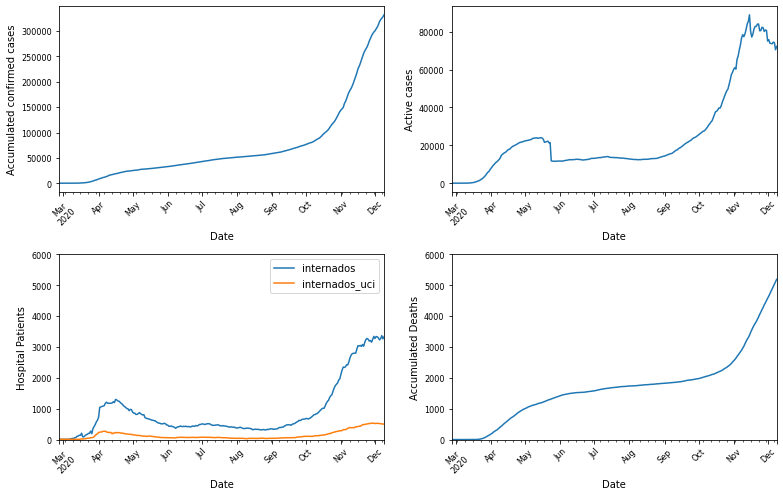

In [187]:
fig, ax = plt.subplots(2,2,figsize = (11,7)) 
data.plot(use_index=True,y=["confirmados"],rot=45,fontsize=8,xlabel="Date",ylabel="Accumulated confirmed cases",legend=False, ax=ax[0,0])
data.plot(use_index=True,y=["ativos"],rot=45,fontsize=8,xlabel="Date",ylabel="Active cases",ax=ax[0,1],legend=False)
data.plot(use_index=True,y=['internados','internados_uci'],rot=45,fontsize=8,xlabel="Date",ylim=(0,6000),
          ylabel="Hospital Patients",ax=ax[1,0])
data.plot(use_index=True,y=["obitos"],rot=45,fontsize=8,xlabel="Date",ylim=(0,6000),ylabel="Accumulated Deaths",ax=ax[1,1],legend=False)
fig.tight_layout(h_pad=1,w_pad=2)
# fig.suptitle('Confirmed cases, Admitted Hospital Patients and Deaths in Portugal', fontsize=12)

Figure 1 - Accumulated confirmed cases (Top Left), active cases (Top Right), admitted hospital patients (Bottom Left) and deaths (Bottom Right) in Portugal, with intense care patients labelled with orange. The second wave appears to start around September.

Country-wide daily new cases can be used to compare the effect of the pandemic on different countries, for example, but even within a single country the incidence varies. Figure 2 shows cases in Braga and Porto grew exponentially before reaching a plateau, while in Lisbon cases grew in a linear fashion. Overall, Portugal saw a major spike in cases in the middle of April. Figure 3 maps how regions in continental Portugal were affected relative to each other.

<AxesSubplot:title={'center':'Country-wide daily new cases'}, xlabel='Date', ylabel='Total count'>

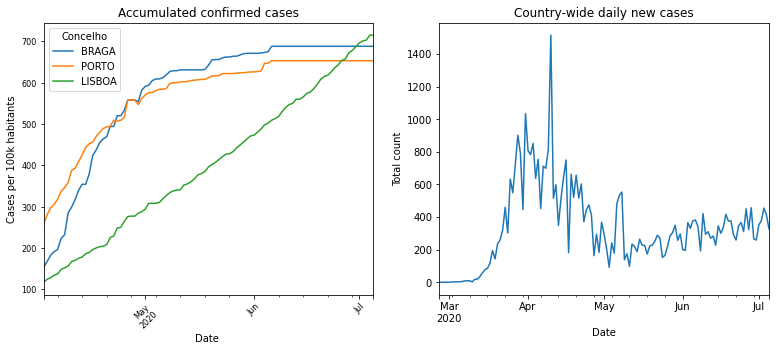

In [188]:
temp_novos = data.loc[data.index <= conc_pop.index[-1],"confirmados_novos"]
# temp_daily = conc_pop.loc[:,["BRAGA","PORTO","LISBOA"]].diff()

fig, ax = plt.subplots(1,2,figsize = (13,5))
conc_pop.plot(use_index=True,y=["BRAGA","PORTO","LISBOA"],rot=45,fontsize=8,\
title="Accumulated confirmed cases",xlabel="Date ",ylabel="Cases per 100k habitants",ax=ax[0])
temp_novos.plot(use_index=True,y=["confirmados_novos"],ax=ax[1],title="Country-wide daily new cases",ylabel="Total count",xlabel="Date")

Figure 2 - Daily accumulated confirmed cases per 100k habitants in three major portuguese cities, namely Braga, Porto and Lisbon (Left) and country-wide daily new cases (Right) for reference. 

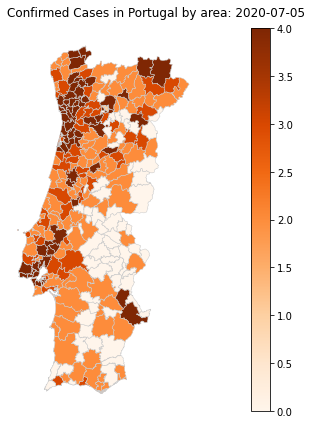

In [189]:
conc_pt_map = geopandas.read_file(CONC_PATH_MAP)
# fix area names
conc_pt_map.rename(columns={"NAME_2":"Concelho"},inplace=True)
conc_pt_map['Concelho'] = conc_pt_map['Concelho'].str.upper()
conc_pt_map['Concelho'].replace(rep_dict,regex=True,inplace=True)

conc_pt_map.loc[conc_pt_map['Concelho'] == 'PRAIA-DA-VITORIA',"Concelho"] = 'VILA-DA-PRAIA-DA-VITORIA'
conc_pt_map.loc[(conc_pt_map['Concelho'] == 'LAGOA') & (conc_pt_map['NAME_1'] == 'Faro'),"Concelho"] = 'LAGOA-(FARO)'
conc_pt_map.loc[(conc_pt_map['Concelho'] == 'CALHETA') & (conc_pt_map['NAME_1'] == 'Azores'),"Concelho"] = 'CALHETA-(AÇORES)'

# split into four categories
categories = conc_pop[-1:].melt(id_vars=[])
# print(categories.describe())
categories['category'] = 1 + np.ceil(categories.value.div(categories.value.quantile(0.25)))
categories['category'] = 1 + np.ceil(categories.value.div(categories.value.median())) #!!!
categories['category'] = categories['category'].clip(0,4)

# # merge map data with concelhos category
# conc_pt_map = conc_pt_map.merge(categories[['Concelho', 'category']], how='right', left_on='Concelho', right_on='Concelho')
conc_pt_map = conc_pt_map.merge(categories[['Concelho', 'category']], how='left', left_on='Concelho', right_on='Concelho')
conc_pt_map["category"].fillna(0,inplace=True)

# # Skip islands to show only continent
conc_pt_map = conc_pt_map[~conc_pt_map.NAME_1.isin(['Azores', 'Madeira'])]

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(f"Confirmed Cases in Portugal by area: {conc_pop.index.format()[-1]}", loc="left", pad=12.0) #mudar titulo
ax.axis('off')
conc_pt_map.plot(column='category',cmap='Oranges',ax=ax,legend=True,linewidth=0.5,edgecolor='0.8')
fig.tight_layout()
# plt.savefig('map.png', dpi=300, bbox_inches='tight')
plt.show()
del conc_pt_map

Figure 3 - Confirmed cases in continental Portugal by smaller area subdivisions. The North of the country has the highest concentration of high case areas.

Another crucial variable in disease are symptoms. Figure 4 plots the daily reported percentage of symptoms relative to confirmed cases, and how it varied wildly in the first months of the pandemic before stabilizing.

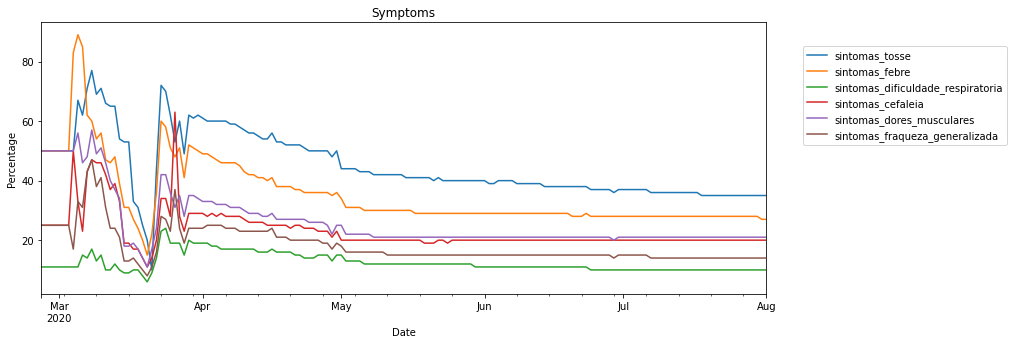

In [190]:
sintomas = [x for x in data.columns if "sintomas" in x]
# data.loc[:,sintomas].value_counts().plot(kind="bar",use_index=True,y=sintomas,ylabel="Total count",title="Symptoms")
fig, ax = plt.subplots(figsize=(13,5))
(data.loc[data.index <= "2020-08-01",sintomas]*100).plot(use_index=True,y=sintomas,ylabel="Percentage",title="Symptoms",ax=ax,xlabel="Date")
plt.legend(loc=(1.05,0.55))

Figure 4 - Percentage of confirmed cases reported to have symptoms. As the data abruptly cuts off after August, only data before August is shown. It appears that symptom percentages stabilize after April.<br>
EN Legend:
+ coughing
+ fever
+ respiratory problems
+ headaches
+ muscle pain
+ generalized weakness.

As the 2019 age group data lacked the gender distribuition, the corresponding values were obtained from the PORDATA portal. As these were from 2011, they were converted to the presumed population in 2019 in the accompanying jupyter notebook "Pordata_process". This simulated 2019 age & gender distribuition data is only used here.<p> One of the main COVID-19 factors responsible for increased risk of death  is older age [7]. Figure 5 plots the number of cases by age and gender, confirming the disproportionate death toll in older age groups.

In [191]:
def plotbyage(variable,mfcols):
    male = data.loc[:,[x[1] for x in mfcols]].copy(deep=True)
    male.insert(len(male.columns),"70_plus",male.loc[:,variable+"_70_79_m"]+male.loc[:,variable+"_80_plus_m"])
    male.drop([variable+"_70_79_m",variable+"_80_plus_m"],axis=1,inplace=True)

    fem = data.loc[:,[x[0] for x in mfcols]].copy(deep=True)
    fem.insert(len(fem.columns),"70_plus",fem.loc[:,variable+"_70_79_f"]+fem.loc[:,variable+"_80_plus_f"])
    fem.drop([variable+"_70_79_f",variable+"_80_plus_f"],axis=1,inplace=True)
    labels = []
    for col in male.columns:
        if "plus" not in col: 
            col2 = "_".join(col.split("_")[1:3])
            colf = col.replace("_m","_f")
        else:
            col2 = col
            colf = col
        labels.append(col2)
        male.loc[:,col] = (male.loc[:,col]*100*100 / gegender.loc[:,("M",col2)].sum()).round(1)
        fem.loc[:,colf] = (fem.loc[:,colf]*100*100 / gegender.loc[:,("F",col2)].sum()).round(1)
    return (male,fem,labels)

import re
conf = [x.split(",") for x in re.findall(r"confirmados_[0-9][0-9]_(?:(?!_m)(?:.|\n))*_m",",".join(data.columns))]
death = [x.split(",") for x in re.findall(r"obitos_[0-9][0-9]_(?:(?!_m)(?:.|\n))*_m",",".join(data.columns))]
conf_m,conf_f,labels =  plotbyage("confirmados",conf)                                              
death_m,death_f,labels = plotbyage("obitos",death)

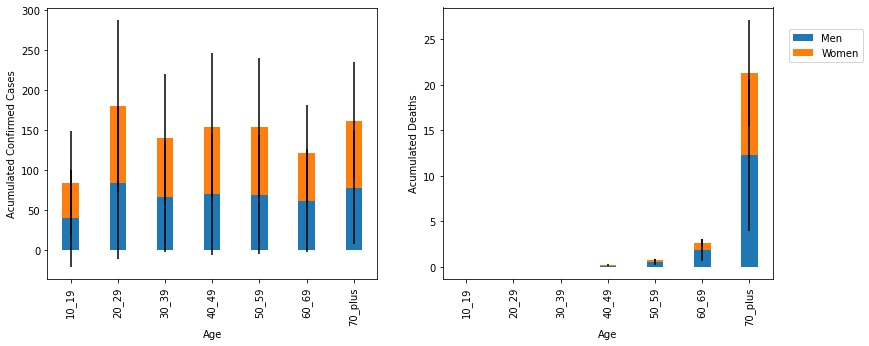

In [192]:
conf_m_means,conf_f_means = conf_m.mean(),conf_f.mean() 
conf_m_std,conf_f_std = conf_m.std(),conf_f.std()
death_m_means,death_f_means = death_m.mean(),death_f.mean()
death_m_std,death_f_std = death_m.std(),death_f.std()
width = 0.35       

fig, ax = plt.subplots(1,2,figsize = (13,5))
ax[0].set_xticks(list(range(len(labels))))
ax[0].set_xticklabels(labels, rotation='vertical')
ax[0].bar(labels, conf_m_means, width, yerr=conf_m_std, label='Men')
ax[0].bar(labels, conf_f_means, width, yerr=conf_f_std, bottom=conf_m_means, label='Women')
ax[0].set_ylabel('Acumulated Confirmed Cases')
ax[0].set_xlabel('Age')

ax[1].set_xticks(list(range(len(labels))))
ax[1].set_xticklabels(labels, rotation='vertical')
ax[1].bar(labels, death_m_means, width, yerr=death_m_std, label='Men')
ax[1].bar(labels, death_f_means, width, yerr=death_f_std, bottom=death_m_means, label='Women')
ax[1].set_ylabel('Acumulated Deaths')
ax[1].set_xlabel('Age')
ax[1].legend(loc=(1.05,0.8))
plt.show()

Figure 5 - Average accumulated confirmed cases (Left) and deaths (Right) in Portugal, normalized by age and gender. Cases seem to be most prevalent in the 20_29 and 70_plus age groups, with deaths only in age groups 40_49 and above, concentrated on the 70_plus group.

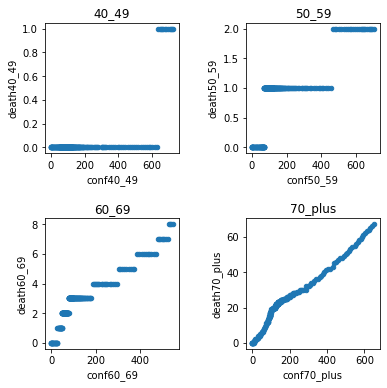

In [193]:
# print(len(conf[3:]),conf[3:])
conf_death = pd.DataFrame()
death_f.columns
labels
i=3
for c in conf_f.columns[3:]: 
    conf_death["conf"+labels[i]] = conf_f[c]+conf_m[c.replace("_f","_m")]
    i+=1
i=3
for d in death_f.columns[3:]: 
    conf_death["death"+labels[i]] = death_f[d]+death_m[d.replace("_f","_m")]
    i+=1
conf_death = conf_death.loc[conf_death.index >= "2020-03-15",:].round().astype("int")

fig, ax = plt.subplots(2,2,figsize = (6,6))
conf_death.plot(kind="scatter",x="conf40_49",y="death40_49",xlabel="Confirmed",ylabel="Deaths",title="40_49",ax=ax[0,0])
conf_death.plot(kind="scatter",x="conf50_59",y="death50_59",xlabel="Confirmed",ylabel="Deaths",title="50_59",ax=ax[0,1])
conf_death.plot(kind="scatter",x="conf60_69",y="death60_69",xlabel="Confirmed",ylabel="Deaths",title="60_69",ax=ax[1,0])
conf_death.plot(kind="scatter",x="conf70_plus",y="death70_plus",xlabel="Confirmed",ylabel="Deaths",title="70_plus",ax=ax[1,1])
plt.subplots_adjust(wspace=0.5,hspace=0.5)

Figure 6 - Plotted relationship between confirmed cases and deaths by age group. The 70_plus age group had an approximately linear relationship.

Text(0.5, 0.98, 'Braga')

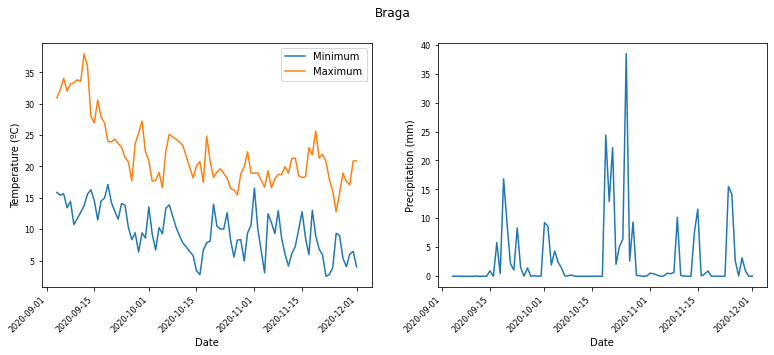

In [194]:
fig, ax = plt.subplots(1,2,figsize = (13,5))
temp_precip.plot(use_index=True,y=[("MinTemp", "BRAGA"),("MaxTemp", "BRAGA")],rot=45,fontsize=8,xlabel="Date",
                 ylabel="Temperature (ºC)",legend=["Mínima","Máxima"], ax=ax[0])
temp_precip.plot(use_index=True,y=[("Precipitation", "BRAGA")],rot=45,fontsize=8,xlabel="Date",
                 ylabel="Precipitation (mm)",ax=ax[1],legend=False)
ax[0].legend(["Minimum", "Maximum"])
fig.suptitle('Braga', fontsize=12)

Figure 7 - Daily minimum and maximum temperature (in Celsius) and precipitation (mm) in the city of Braga over time.

<h3>Statistical Analysis

we tested our hypothesis that confirmed cases and deaths varied not only between age groups, but also gender. Since the Shapiro-Wilk normality test returned a p-value > 0.05, the confirmed case data by age/gender is assumed to be normal and paremetric tests can be used. After testing if the female and male datasets had equal variances, the parametric t-test was used.<p>As the ttest_ind p-value > 0.05, the null hypothesis is not rejected. In conclusion, there is no significant difference between confirmed cases in men and women. As expected since the deaths by age/gender were highly schewed towards older age groups, the data is not considered normal. As such, the nonparametric mannwhitney test was used instead and no significant difference in deaths by gender was found.

In [195]:
from scipy import stats
# print("Average confirmed cases:\n",conf_f_means,"(F) vs (M)\n",conf_m_means,"\n")
print("Shapiro normality test - Assumed normal if p-value > 0.05")
print("conf_f_means:",stats.shapiro(conf_f_means))
print("conf_m_means:",stats.shapiro(conf_m_means))
print("death_f_means:",stats.shapiro(death_f_means))
print("death_m_means:",stats.shapiro(death_m_means),"\n")

print("Bartlett parametric equal variances test - assumed equal if p-value > 0.05")
print(stats.bartlett(conf_f_means,conf_m_means))
print("Independent samples t-test - Assumed equal means if p-value > 0.05")
print(stats.ttest_ind(conf_f_means,conf_m_means,equal_var=True),end="\n\n")
print("Mannwhitney nonparametric test - Assumed equal if p-value > 0.05")
print(stats.mannwhitneyu(death_f_means,death_m_means))

# del conf_m_means,conf_f_means,death_m_means,death_f_means
# del death_m_std,death_f_std,conf_m_std,conf_f_std,labels

Shapiro normality test - Assumed normal if p-value > 0.05
conf_f_means: ShapiroResult(statistic=0.9059021472930908, pvalue=0.3682290315628052)
conf_m_means: ShapiroResult(statistic=0.9112962484359741, pvalue=0.4049224257469177)
death_f_means: ShapiroResult(statistic=0.5111854076385498, pvalue=2.28168264584383e-05)
death_m_means: ShapiroResult(statistic=0.5591626167297363, pvalue=8.870859892340377e-05) 

Bartlett parametric equal variances test - assumed equal if p-value > 0.05
BartlettResult(statistic=0.27838371899530595, pvalue=0.5977625465536609)
Independent samples t-test - Assumed equal means if p-value > 0.05
Ttest_indResult(statistic=0.9200994952244854, pvalue=0.37564677318139517)

Mannwhitney nonparametric test - Assumed equal if p-value > 0.05
MannwhitneyuResult(statistic=21.0, pvalue=0.34751469713161476)


To later study the difference between first and second waves, we divide the country-wide COVID-19 dataset ("data"). The first wave was defined as ending in August.

In [196]:
data_first_wave = data[data.index < "2020-08-01"].drop(["Weekday_Name"],axis=1)  #"2020-07-01"
data_sec_wave = data[data.index >= "2020-08-01"].drop(["Weekday_Name"],axis=1)
print("data_first_wave shape:",data_first_wave.shape)
print(data_first_wave.loc[data_first_wave.index[-5:],"confirmados_novos"],end="\n\n")
print("data_sec_wave shape:",data_sec_wave.shape)
print(data_sec_wave.loc[data_sec_wave.index[-5:],"confirmados_novos"]) #,end="\n\n"
# data_first_wave.dtypes.value_counts()

data_first_wave shape: (157, 85)
data
2020-07-27    135
2020-07-28    111
2020-07-29    203
2020-07-30    255
2020-07-31    204
Name: confirmados_novos, dtype: int64

data_sec_wave shape: (131, 85)
data
2020-12-05    6087
2020-12-06    3834
2020-12-07    2597
2020-12-08    2905
2020-12-09    4097
Name: confirmados_novos, dtype: int64


During major holidays, people tend to visit their families. In a pandemic, this can lead to spikes in case numbers after the holiday. For example, we compare the daily new cases in the weeks before and after Christmas. If only considering the 7 days after Christmas, the difference in cases is not significant. This is expected, as there is a lag period after infection.

extra_data Shape: (30, 85)
Date range: 2020-12-10 00:00:00 - 2021-01-08 00:00:00 

Mannwhitney nonparametric test - Assumed equal if p-value > 0.05
MannwhitneyuResult(statistic=46.0, pvalue=0.4260217231761402)


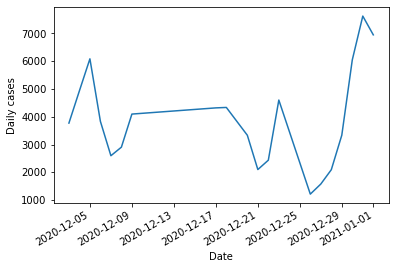

In [197]:
print("extra_data Shape:",extra_data.shape)
print("Date range:",extra_data.index[0],"-",extra_data.index[-1],"\n")

antes_natal = pd.concat(
    (data.loc[data.index[-7:],"confirmados_novos"],
    extra_data.loc[extra_data[extra_data.index < "2020-12-25"][-7-1:-1].index,"confirmados_novos"]),axis=0)
depois_natal = extra_data.loc[extra_data[extra_data.index > "2020-12-25"].index,"confirmados_novos"]
depois_natal = depois_natal[:min(len(depois_natal),7)]
depois_natal_14 = depois_natal[7:min(len(depois_natal),14)] #no data yet

print("Mannwhitney nonparametric test - Assumed equal if p-value > 0.05")
print(stats.mannwhitneyu(antes_natal,depois_natal))

temp_natal = pd.concat((antes_natal,depois_natal),axis=0)
temp_natal.plot(use_index=True,xlabel="Date",ylabel="Daily cases")
del temp_natal

Figure 7 - Daily new confirmed cases in Portugal in December.

Unfortunately, we could only retrieve meteorological data from September onwards, after the shift from daily to weekly COVID-19 data. Coupled with the small number of entries, the unwieldy format of weekly averages meant that the connection between temperature/precipitation and number of cases was not explored.

In [198]:
conc_data_new2 = conc_data_new.loc[conc_data_new.index.get_level_values(1)=="BRAGA",["confirmados_1","incidencia"]]
conc_data_new2.index = [x[0] for x in conc_data_new2.index]

mintemp = temp_precip.loc[:,("MinTemp","BRAGA")]
print(mintemp.resample("W-MON").mean(),end="\n\n")
print(conc_data_new2)

del temp_precip,mintemp,conc_data_new2

Date
2020-09-07    15.097914
2020-09-14    13.596774
2020-09-21    14.262446
2020-09-28    10.568456
2020-10-05     9.576461
2020-10-12    10.863277
2020-10-19     5.756016
2020-10-26    10.146770
2020-11-02     9.734345
2020-11-09     9.564363
2020-11-16     7.839590
2020-11-23     6.568042
2020-11-30     6.306644
2020-12-07     4.000160
Freq: W-MON, Name: (MinTemp, BRAGA), dtype: float64

            confirmados_1  incidencia
2020-11-11            108       824.0
2020-11-20            159      1221.0
2020-11-26            177      1354.0
2020-03-12            152      1168.0
2020-09-12            125       956.0
2020-12-18            103       789.0
2020-12-21             88       675.0
2020-12-28             82       632.0


Most socio-economic variables had a significant (> |0.5|) corrrelation with the non-normalized COVID cases by area, but none were highly correlated with the normalized data.

Text(0.5, 1.0, 'Correlation Matrix')

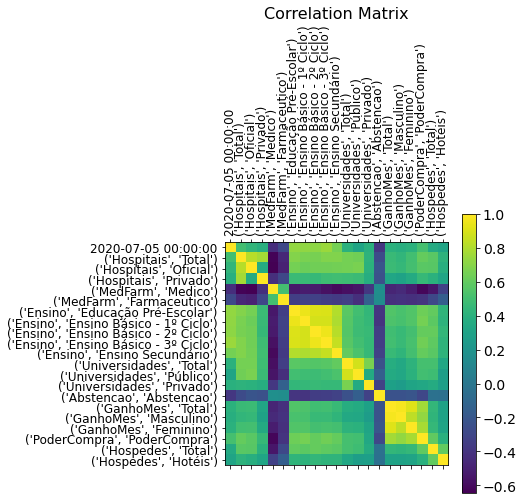

In [199]:
conc_pop2 = conc_data.tail(1).transpose().filter(more_pordata.index,axis=0)
latest = pd.concat((conc_pop2,more_pordata),axis=1) 
#correlation != causation
#default is pearson which is parametric!
corr = latest.corr(method="spearman")

f = plt.figure(figsize=(5, 5))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(latest.shape[1]), latest.columns.get_level_values(0), fontsize=12, rotation=90)
plt.yticks(range(latest.shape[1]), latest.columns.get_level_values(0), fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

Figure 8 - Spearman (non-parametric) correlation heatmap between socio-economic variables and confirmed cases by area subdivision.

In [200]:
latest_cls = latest.copy(deep=True)
for c in latest_cls.columns: 
    temp = 1 + np.ceil(latest_cls[c].div(latest_cls[c].mean()))
    latest_cls[c] = temp.clip(0,6) #.astype("int")
# print(latest_cls.iloc[:,0].value_counts())
corr_cls = latest_cls.corr(method="spearman")

print("High correlation with original data:\n",corr.loc[corr.iloc[:,0].abs()>=0.5,corr.columns[0]],end="\n\n")
print("High correlation with classified data:\n",corr_cls.loc[corr_cls.iloc[:,0].abs()>=0.5,corr_cls.columns[0]],end="\n\n")
del latest_cls,corr_cls

High correlation with original data:
 2020-07-05 00:00:00                   1.000000
(Hospitais, Total)                    0.502883
(Ensino, Educação Pré-Escolar)        0.736361
(Ensino, Ensino Básico - 1º Ciclo)    0.728483
(Ensino, Ensino Básico - 2º Ciclo)    0.717423
(Ensino, Ensino Básico - 3º Ciclo)    0.750650
(Ensino, Ensino Secundário)           0.658313
(PoderCompra, PoderCompra)            0.513688
Name: 2020-07-05 00:00:00, dtype: float64

High correlation with classified data:
 2020-07-05 00:00:00                   1.000000
(Ensino, Educação Pré-Escolar)        0.729175
(Ensino, Ensino Básico - 1º Ciclo)    0.714313
(Ensino, Ensino Básico - 2º Ciclo)    0.756615
(Ensino, Ensino Básico - 3º Ciclo)    0.698817
(Ensino, Ensino Secundário)           0.679074
Name: 2020-07-05 00:00:00, dtype: float64



<h3>Unsupervised multivariate analysis

Unsupervised machine learning methods include hierarchical clustering, principal component analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE). Hierarchical clustering seeks to build a hierarchy of clusters, using agglomerative ("bottom-up", single clusters to grouped) or divisive ("top-down", single grouped to many clusters) methods, based on similiarity metrics, such as euclidean distance.<p>
PCA is an exploratory analysis technique for multidimensional data. PCA has the objective of converting the original data (typically correlated) in a set of non-correlated variables, or principal components, which explain most of the data's variability. tSNE is a similar technique to PCA, but probabilistic and better suited for unbalanced datasets.
<p> Figure 8 presents a dendogram of the hierarchical clustering of the accumualted confirmed cases by area, already normalized by 100k habitants, to better understand how the areas of the country are related.

In [201]:
nuts2_conc = pd.read_csv(os.path.join(ROOT_FOLDER,"wiki_nuts2_concelhos.csv"),header=0,usecols=["Nível II","Concelhos"])
nuts2_conc['Concelhos'] = nuts2_conc['Concelhos'].str.upper()
nuts2_conc['Concelhos'].replace(rep_dict,regex=True,inplace=True)
nuts2_conc['Nível II'] = nuts2_conc['Nível II'].str.upper()
nuts2_conc['Nível II'].replace(rep_dict,regex=True,inplace=True)

nuts2_conc = nuts2_conc.merge(conc_get[['Concelho']], how='right', left_on='Concelhos', right_on='Concelho')
nuts2_conc = nuts2_conc.dropna(subset=["Concelhos"]) #.filter(conc_pop.columns,axis=0)
#filter mismatching areas
diff = set(conc_pop.columns).difference(set(nuts2_conc["Concelhos"]))
nuts2_conc = nuts2_conc.loc[~nuts2_conc["Concelhos"].isin(diff),:]
print(nuts2_conc["Nível II"].value_counts(),end="\n\n")
# print(conc_pop.shape,nuts2_conc.shape)

colors = {'REGIAO-DO-CENTRO': 'r', 'REGIAO-DO-NORTE': 'g', 'ALENTEJO': 'b',"REGIAO-DE-LISBOA":"m","ALGARVE":"y"}
label_colors = dict(zip(nuts2_conc["Concelhos"],nuts2_conc["Nível II"]))
for k,v in label_colors.items(): label_colors[k] = colors[v]
# print(label_colors)
# print("Mean distribution:\n",conc_pop.mean().describe(),end="\n\n")
# print("Standard deviation distribution:\n",conc_pop.std().describe())

REGIAO-DO-CENTRO    80
REGIAO-DO-NORTE     73
ALENTEJO            27
REGIAO-DE-LISBOA    18
ALGARVE             11
Name: Nível II, dtype: int64



According to the colored labels by general region of the country, areas in the North of Portugal (in green) are most similar to each other, as they are more likely to be concentrated together in clusters. Areas labelled in black do not have a mapped region due to name mismatch.
<p>In both dendograms, the  most distinct cluster is composed of Vila-Nova-de-Foz-Coa (near the border with Spain) and Ovar (South of Porto), despite not being close geographically. As mentioned before, these two areas had one of the highest case counts per 100k habitants in the tail end of the first wave (2020-07-05).

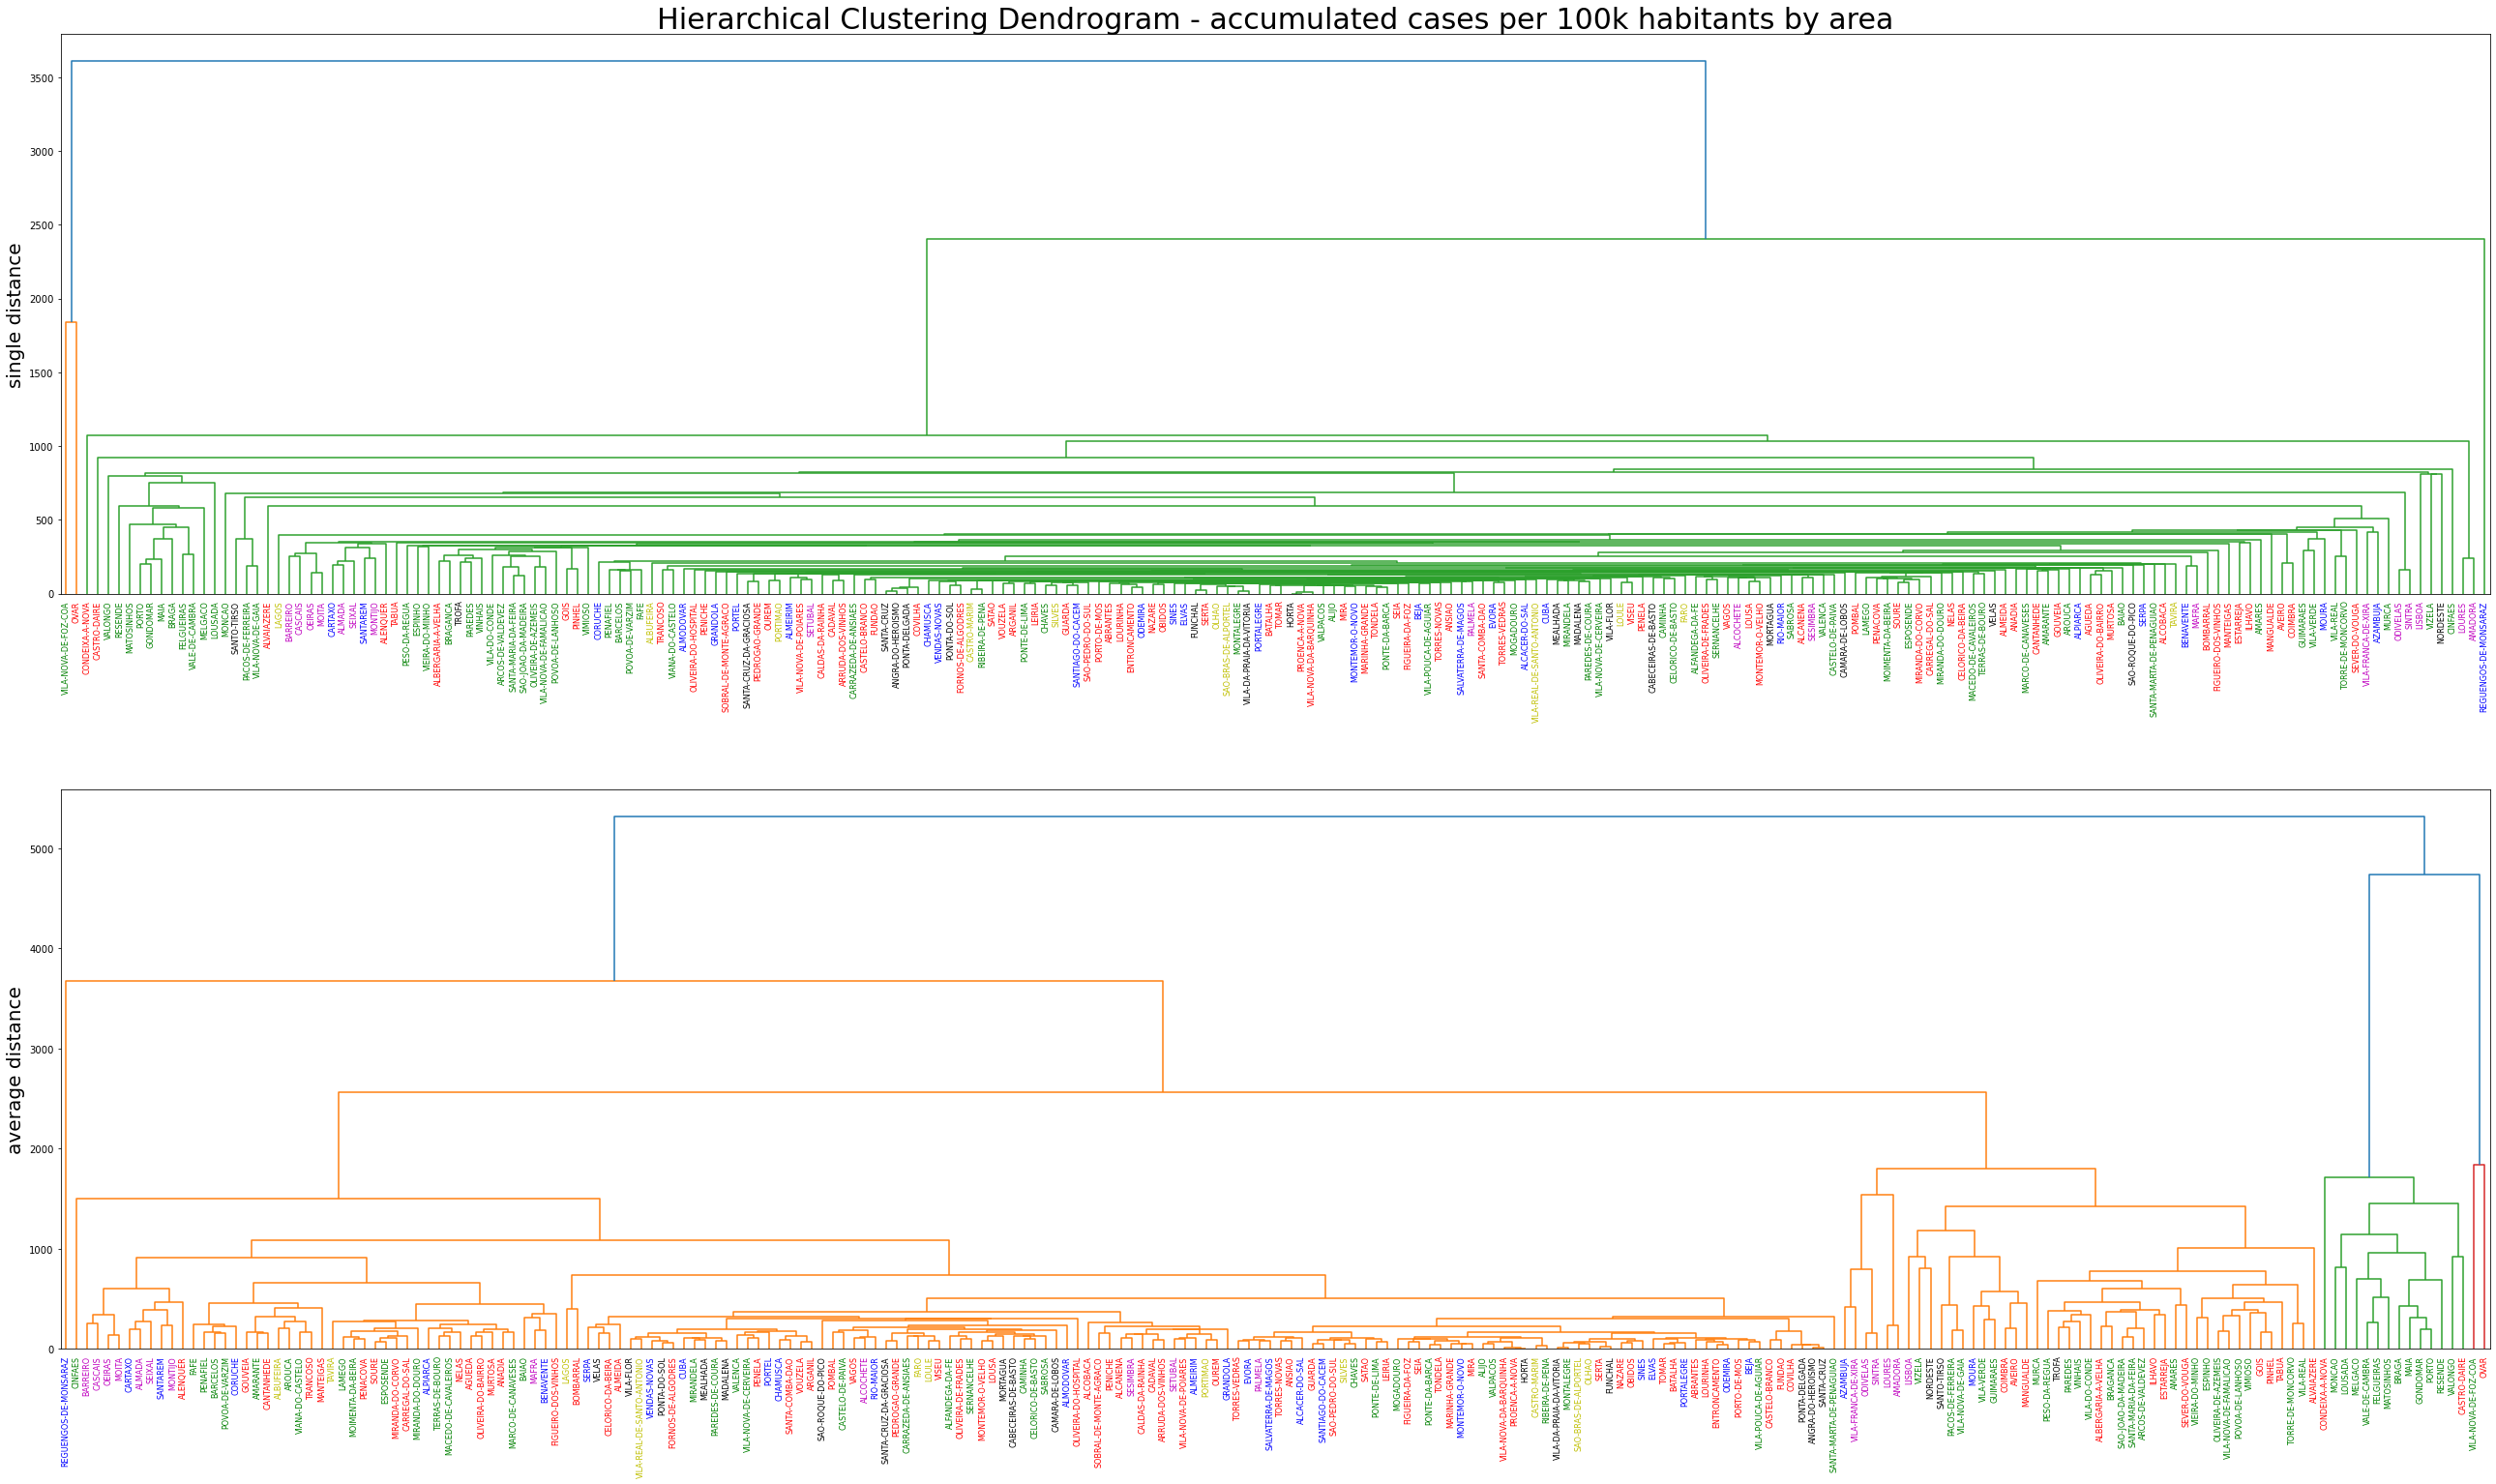

In [202]:
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage

# conc_data2 = conc_data.transpose().filter(more_pordata.index,axis=0)
#conc_pop.transpose()
Z = linkage(conc_pop.transpose(), method='single', metric='euclidean',optimal_ordering=True)
Zav = linkage(conc_pop.transpose(), method='average', metric='euclidean',optimal_ordering=True)

# calculate full dendrogram
fig, ax = plt.subplots(2,1,figsize=(45, 25))
Z1 = dendrogram(Z, orientation='top', labels=list(conc_pop.columns),leaf_font_size=8,ax=ax[0])
Z2 = dendrogram(Zav, orientation='top', labels=list(conc_pop.columns),leaf_font_size=8,ax=ax[1]) 
ax[0].set_title('Hierarchical Clustering Dendrogram - accumulated cases per 100k habitants by area',fontsize=30)
ax[0].set_ylabel('single distance',fontsize=20)
ax[1].set_ylabel('average distance',fontsize=20)
plt.subplots_adjust(hspace=0.35)

# ax = plt.gca()
xlbls0 = ax[0].get_xmajorticklabels()
xlbls1 = ax[1].get_xmajorticklabels()
for lbl in xlbls0: 
    if lbl.get_text() in label_colors.keys(): lbl.set_color(label_colors[lbl.get_text()])
    else: lbl.set_color("black")
for lbl in xlbls1: 
    if lbl.get_text() in label_colors.keys(): lbl.set_color(label_colors[lbl.get_text()])
    else: lbl.set_color("black")

plt.show()
# #COLORIR POR REGIAO

Figure 9 - Hierarchical clustering dendrogram of the normalized accumulated confirmed cases per 100 000 habitants on 2020-07-05, by area, comparing the single (Top) and average (Bottom) linkage methods. The average linkage method appears to better discriminate clusters.

PCA and tSNE were also performed on the same normalized case data by area ("conc_pop"). Neither method could clearly separate the data into distinct clusters.

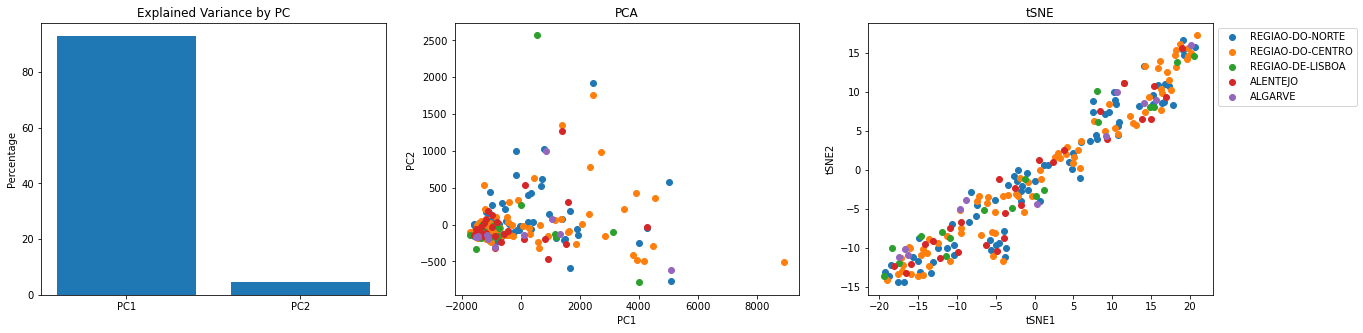

In [203]:
from sklearn.decomposition import PCA
pca_data = PCA(n_components=0.95) #n_iter=1000?
pca_data.fit(conc_pop.transpose())
x_reduced = pca_data.transform(conc_pop.transpose())

i95 = np.where(pca_data.explained_variance_ratio_.cumsum()*100 >= 95)[0][0]

fig, ax = plt.subplots(1,3,figsize=(21, 5))
ax[0].bar(range(max(2,i95)), pca_data.explained_variance_ratio_[:max(2,i95)]*100)
ax[0].set_xticks(range(max(2,i95)))
ax[0].set_xticklabels(['PC'+str(i) for i in range(1,max(3,i95+1))])
ax[0].set_title("Explained Variance by PC")
ax[0].set_ylabel("Percentage")

for nuts in nuts2_conc["Nível II"].unique():
    sp = nuts2_conc.index[nuts2_conc["Nível II"]==nuts]-1
    ax[1].plot(x_reduced[sp,0],x_reduced[sp,1], 'o' , label=nuts)
ax[1].set_title("PCA")
# ax[1].legend(bbox_to_anchor=(1, 1), shadow=False) #bbox_to_anchor=(1.05, 1)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')

from sklearn.manifold import TSNE
tsne = TSNE() 
points = tsne.fit_transform(conc_pop.transpose())

for nuts in nuts2_conc["Nível II"].unique():
    sp = nuts2_conc.index[nuts2_conc["Nível II"]==nuts]-1
    ax[2].plot(points[sp,0],points[sp,1], 'o' , label=nuts)
ax[2].set_title("tSNE")
ax[2].set_xlabel('tSNE1') 
ax[2].set_ylabel('tSNE2')
ax[2].legend(bbox_to_anchor=(1, 1), shadow=False)

plt.show()

Figure 10 - PCA and tSNE of the accumulated confirmed cases by area, normalized by population. Left: Percentage of variance explained per component up to the component reaching 95% explained variance (minimum of 2); Center: PC1 and PC2 plotted; Right: tSNE1 and tSNE2 plotted.

<h3>Supervised Machine Learning

We attempted to train supervised machine learning models to predict the next day's number of cases or deaths, using as input the previous day's new cases and cases by age group (70-79), respectively. After creating the train/test datasets, we search for the best algorithm for each regression problem and test the effects of different scaling methods.

Case Train: (244, 1) (244,) Test: (69, 1) (69,)
Death Train: (244, 1) (244,) Test: (39, 1) (39,)



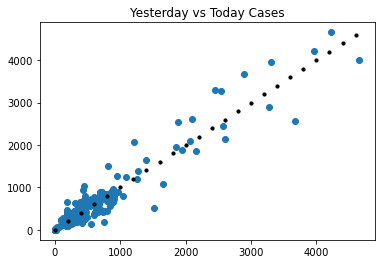

In [204]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred): 
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
#predict cases
data_full = pd.concat((data.drop(['Weekday_Name'],axis=1),extra_data.drop(['Weekday_Name'],axis=1)),axis=0)
case_predict = pd.DataFrame(data_full.loc[:,"confirmados_novos"],columns=["confirmados_novos"])
case_predict.insert(1,"yesterday",data_full.loc[:,"confirmados_novos"].shift())
case_predict.insert(2,"diff",case_predict["yesterday"].diff())
case_predict = case_predict.loc[case_predict.index>="2020-03-02",:].fillna(0)

# case_Xtest = case_predict.loc[case_predict.index >= "2020-10-01",:].drop(['confirmados_novos'], axis = 1)
case_Xtrain = np.array(case_predict.loc[case_predict.index < "2020-11-01","yesterday"])
case_Xtrain = case_Xtrain.reshape((case_Xtrain.shape[0],1))
case_Ytrain = np.array(case_predict.loc[case_predict.index < "2020-11-01","confirmados_novos"])
case_Ytrain = case_Ytrain.reshape((case_Ytrain.shape[0],))

case_Xtest = np.array(case_predict.loc[case_predict.index >= "2020-11-01","yesterday"])
case_Xtest = case_Xtest.reshape((case_Xtest.shape[0],1))
case_Ytest = np.array(case_predict.loc[case_predict.index >= "2020-11-01","confirmados_novos"])
case_Ytest = case_Ytest.reshape((case_Ytest.shape[0],))
print("Case Train:",case_Xtrain.shape,case_Ytrain.shape,"Test:",case_Xtest.shape,case_Ytest.shape)

plt.scatter(case_Xtrain,case_Ytrain)
plt.scatter(list(range(0,int(case_Xtrain[-1,0]),200)),list(range(0,int(case_Xtrain[-1,0]),200)),c="black",s=10)
plt.title("Yesterday vs Today Cases")

# predict deaths
death_predict = pd.DataFrame() #2020-03-18?
death_predict["confirmados_70_79"] = data_full.loc[data_full.index>="2020-04-01","confirmados_70_79_f"]+ \
            data_full.loc[data_full.index>="2020-04-01","confirmados_70_79_m"]
death_predict["obitos_70_79"] = data_full.loc[data_full.index>="2020-04-01","obitos_70_79_f"]+ \
            data_full.loc[data_full.index>="2020-04-01","obitos_70_79_m"]

death_Xtrain = np.array(death_predict.loc[death_predict.index < "2020-12-01",death_predict.columns[:-1]])
death_Ytrain = np.array(death_predict.loc[death_predict.index < "2020-12-01",death_predict.columns[-1]])
death_Ytrain = death_Ytrain.reshape((death_Ytrain.shape[0],))

death_Xtest = np.array(death_predict.loc[death_predict.index >= "2020-12-01",death_predict.columns[:-1]])
death_Ytest = np.array(death_predict.loc[death_predict.index >= "2020-12-01",death_predict.columns[-1]])
death_Ytest = death_Ytest.reshape((death_Ytest.shape[0],))

print("Death Train:",death_Xtrain.shape,death_Ytrain.shape,"Test:",death_Xtest.shape,death_Ytest.shape,end="\n\n")

Figure 11 - Seemingly linear relationship between cases a day apart (Yesterday vs Today).

The model quality of 4 regression models, namely linear regression, neural networks or multilayer perceptron, K-nearest neighbours and random forests, were evaluated using the r2 score metric and k-fold cross validation. Cross validation divides a dataset into k mutually exclusive datasets, where k-1 sets are used as train data the final set is the test data, repeating the process k times. As the dataset is not very large, cross validation only employed 3 mutually exclusive time series datasets.
<p>The "sklearn.metrics.r2_score" metric's best possible score is 1 and negative values are possible, where the algorithms get arbitrarily worse. Out of the 4 regression models tested for the unscaled case regression, the linear regression (LR) and neural network (NN) models performed best, but still had only a small r2 average (0.4). In contrast, all models performed poorly for the death regression.

Cases
LR: 0.373965 (0.338381)
NN: 0.370905 (0.295910)
KNN: -0.565603 (0.629171)
RF: -0.771023 (0.722371)
Deaths
LR: -7.761209 (6.770609)
NN: -7.618755 (6.573181)
KNN: -2.703369 (1.212489)
RF: -2.507976 (1.089027)


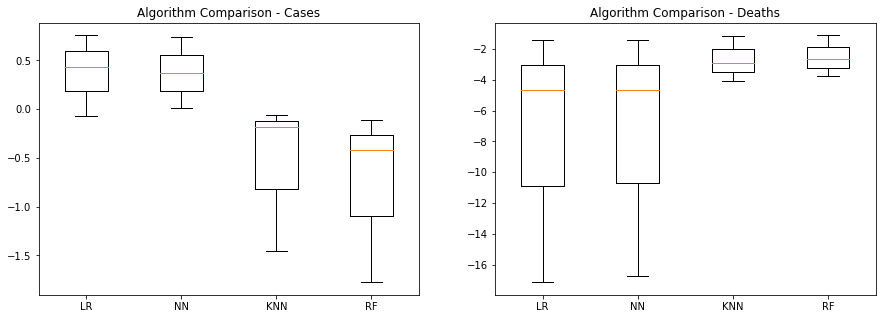

In [205]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
tscv3 = TimeSeriesSplit(n_splits=3)
np.random.seed(4) #for reproducibility
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings(): 
    def RegressionCV(X,Y,cv):
        models = []
        models.append(('LR', LinearRegression()))
        models.append(('NN', MLPRegressor(solver = 'lbfgs',max_iter=1000, hidden_layer_sizes=(50,))))
        models.append(('KNN', KNeighborsRegressor())) 
        models.append(('RF', RandomForestRegressor(n_estimators = 10))) #,max_depth=10
        results = []
        names = []
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        for name, model in models:
            cv_results = cross_val_score(model, X, Y, cv=cv, scoring='r2')
            results.append(cv_results)
            names.append(name)
            print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        return results,names

print("Cases")
results_c,names_c = RegressionCV(case_Xtrain,case_Ytrain,tscv3)
print("Deaths")
results_d,names_d = RegressionCV(death_Xtrain,death_Ytrain,tscv3)

fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].boxplot(results_c, labels=names_c)
ax[0].set_title('Algorithm Comparison - Cases')
ax[1].boxplot(results_d, labels=names_d)
ax[1].set_title('Algorithm Comparison - Deaths')
plt.show()

# del death_Xtrain,death_Ytrain,death_Xtest,death_Ytest

Figure 12 - Algorithm comparison for the confirmed case (Left) and death (Right) machine learning regressions.

As data scaling is often crucial for machine learning pre-processing, different scaling methods and the resulting models were evaluated. The 4 scaling methods were division by standard deviation, subtraction of mean, z-score (the previous 2 simultaneously) and fitted scaling. Overall, the linear regression models performed best regardless of scaling method, with the exception of the K-nearest neighbour models using mean subtraction.

Cases - standard deviation
LR: 0.373965 (0.338381)
NN: -0.946780 (0.999356)
KNN: -0.548835 (0.649821)
RF: -0.774951 (0.732991)

Cases - mean
LR: 0.106442 (0.150531)
NN: -0.235926 (0.333649)
KNN: 0.592363 (0.576486)
RF: -0.148780 (0.210407)

Cases - full normalization
LR: 0.373965 (0.338381)
NN: -2.087373 (2.448145)
KNN: -0.565524 (0.629219)
RF: -0.559802 (0.474342)

Cases - fitted full normalization
LR: 0.373965 (0.338381)
NN: -0.833522 (0.904049)
KNN: -0.565524 (0.629219)
RF: -0.623023 (0.562468)


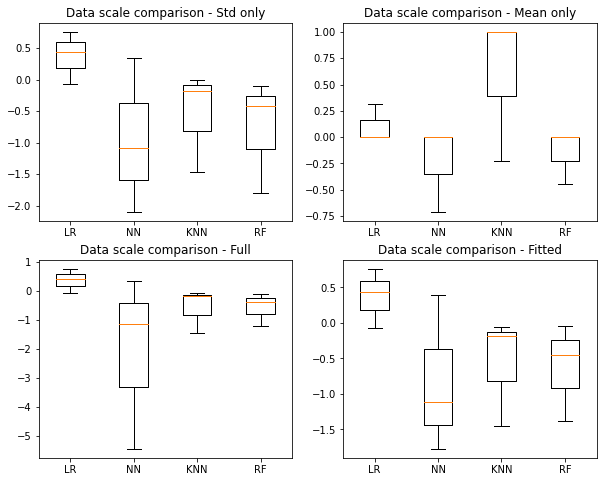

In [206]:
np.random.seed(4) #for reproducibility

print("Cases - standard deviation")
results_std,names = RegressionCV(case_Xtrain/np.std(case_Xtrain),case_Ytrain/np.std(case_Ytrain),tscv3)
print()
print("Cases - mean")
case_Xtrain_mn = case_Xtrain-np.mean(case_Xtrain)
case_Xtrain_mn[case_Xtrain_mn<0] = 0
case_Ytrain_mn = case_Ytrain-np.mean(case_Xtrain)
case_Ytrain_mn[case_Ytrain_mn<0] = 0
results_mn,names = RegressionCV(case_Xtrain_mn,case_Ytrain_mn,tscv3)
print()
print("Cases - full normalization")
from sklearn.preprocessing import scale
case_Xtrain_sc = scale(case_Xtrain)
case_Ytrain_sc = scale(case_Ytrain)
results_sc,names = RegressionCV(case_Xtrain_sc,case_Ytrain_sc,tscv3)
print()
print("Cases - fitted full normalization")
from sklearn.preprocessing import StandardScaler
scalerx = StandardScaler().fit(case_Xtrain)
scalery = StandardScaler().fit(case_Ytrain.reshape((case_Ytrain.shape[0],1)))
case_Xtrain_fit = scalerx.transform(case_Xtrain)
case_Ytrain_fit = scalery.transform(case_Ytrain.reshape((case_Ytrain.shape[0],1)))
results_fit,names = RegressionCV(case_Xtrain_fit,case_Ytrain_fit.reshape((case_Ytrain.shape[0],)),tscv3)

fig, ax = plt.subplots(2,2,figsize=(10, 8))
ax[0,0].boxplot(results_std, labels=names)
ax[0,0].set_title('Data scale comparison - Std only')
ax[0,1].boxplot(results_mn, labels=names)
ax[0,1].set_title('Data scale comparison - Mean only')
ax[1,0].boxplot(results_sc, labels=names)
ax[1,0].set_title('Data scale comparison - Full')
ax[1,1].boxplot(results_fit, labels=names)
ax[1,1].set_title('Data scale comparison - Fitted')
plt.show()

Figure 13 - Scaling method and resulting machine learning regression model quality comparison, using the r2 metric.

Finally, the predictions of the linear regression models using fitted normalization data were plotted against the real case counts. The graph shows that the model predictions are highly dispersed, as shown by the low r2 metric, frequently over or underestaming the number of confirmed cases.

LR pred vs real
explained_variance:  0.3269
r2:  0.3249
MAE:  1.5471
MSE:  4.4561
RMSE:  2.1109


Text(0.5, 1.0, 'LR predictions')

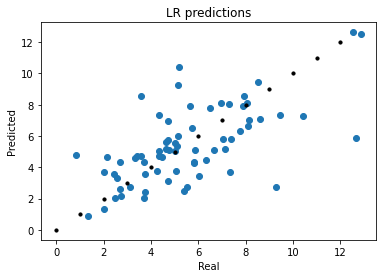

In [207]:
np.random.seed(4) #for reproducibility

case_Xtest_mn = case_Xtest-case_Xtest.mean()
case_Ytest_mn = scalery.transform(case_Ytest.reshape((case_Ytest.shape[0],1)))
LR = LinearRegression().fit(case_Xtrain_fit,case_Ytrain_fit.reshape((case_Ytrain.shape[0],)))
LRpred = LR.predict(case_Xtest_fit)

print("LR pred vs real")
# print(dict(zip(LRpred[-5:],case_Ytest_fit[-5:])))
regression_results(case_Ytest_fit,LRpred)

plt.scatter(case_Ytest_fit,LRpred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.scatter(list(range(0,13,1)),list(range(0,13,1)),c="black",s=10) #perfect y=x for reference
plt.title('LR predictions')

Figure 14 - Cases predicted by a linear regression machine learning model in comparison to the real values.

### Deep Learning

Goal: given the cases of the previous days as input, the deep learning model attempts to predict the next day's confirmed cases.

In [208]:
conf_full = pd.concat((data_full.loc[:,"confirmados_novos"].shift(7).rename("look_back7"),
                      data_full.loc[:,"confirmados_novos"].shift(6).rename("look_back6"),
                      data_full.loc[:,"confirmados_novos"].shift(5).rename("look_back5"),
                      data_full.loc[:,"confirmados_novos"].shift(4).rename("look_back4"),
                      data_full.loc[:,"confirmados_novos"].shift(3).rename("look_back3"),
                      data_full.loc[:,"confirmados_novos"].shift(2).rename("look_back2"),
                      data_full.loc[:,"confirmados_novos"].shift(1).rename("look_back1"),
                      data_full.loc[:,"confirmados_novos"].rename("today")),axis=1)
conf_full = conf_full.loc[conf_full.index>="2020-03-09",:].astype("int")
# conf_full

column_indices = {name: i for i, name in enumerate(conf_full.columns)}
n = len(conf_full)
train_df = conf_full.iloc[0:int(n*0.7),:]
val_df = conf_full.iloc[int(n*0.7):int(n*0.9),:]
test_df = conf_full.iloc[int(n*0.9):,:]
num_features = conf_full.shape[1]

scalerx = StandardScaler().fit(conf_full)
train_df_fit = scalerx.transform(train_df)
val_df_fit = scalerx.transform(val_df)
test_df_fit = scalerx.transform(test_df)

print("train_df_fit:",train_df_fit.shape,"val_df_fit:",val_df_fit.shape,"test_df_fit:",test_df_fit.shape)

train_df_fit: (214, 8) val_df_fit: (61, 8) test_df_fit: (31, 8)


Data Windowing
+ Indexes and offsets
+ Split
+ Create tf.data.Datasets
+ Baseline

In [209]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

window = WindowGenerator(input_width=7,label_width=1,shift=1,train_df=train_df,val_df=val_df,test_df=test_df,
                         label_columns=["today"])
window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['today']

In [210]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

import tensorflow as tf
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size]),
                           np.array(train_df[200:200+window.total_window_size])])


example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self): return self.make_dataset(self.train_df)

@property
def val(self): return self.make_dataset(self.val_df)

@property
def test(self): return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

All shapes are: (batch, time, features)
Window shape: (3, 8, 8)
Inputs shape: (3, 7, 8)
labels shape: (3, 1, 1)


In [211]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,label_columns=['today'])
print(single_step_window)

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]
    
# baseline = Baseline(label_index=column_indices["today"])

# baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

# val_performance = {}
# performance = {}
# #???
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
# performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['today']


In [212]:
# linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

# MAX_EPOCHS = 20

# def compile_and_fit(model, window, patience=2):
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

#     model.compile(loss=tf.losses.MeanSquaredError(),
#                 optimizer=tf.optimizers.Adam(),
#                 metrics=[tf.metrics.MeanAbsoluteError()])

#     history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])
#     return history

# history = compile_and_fit(linear, single_step_window)

# val_performance['Linear'] = linear.evaluate(single_step_window.val)
# performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [213]:
# plt.bar(x = range(len(train_df.columns)),
#         height=linear.layers[0].kernel[:,0].numpy())
# axis = plt.gca()
# axis.set_xticks(range(len(train_df.columns)))
# _ = axis.set_xticklabels(train_df.columns, rotation=90)

In [214]:
# #usar dados covid antes + etc -> confirmados depois
# #ex: LSTM
# from keras.models import Sequential
# from keras.layers import Dense, SimpleRNN
# from keras.callbacks import EarlyStopping

# def model_rnn(look_back):
#     model=Sequential()
#     model.add(SimpleRNN(units=32, input_shape=(1,look_back), activation="relu"))
#     model.add(Dense(8, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
#     return model

## References
[1] PT COVID-19 Dataset(s): https://github.com/dssg-pt/covid19pt-data<br>
[2] Unless stated otherwise, all non-COVID data was retrieved from: https://www.pordata.pt/<br>
[3] Meteorological data: http://api.ipma.pt/#services<br>
[4] Area code data (concelhos/distritos) (ipma data extraction): https://github.com/centraldedados/codigos_postais<br>
[5] General area data (NUTS/concelho): https://pt.wikipedia.org/wiki/Lista_de_concelhos_por_NUTS,_distritos_e_ilhas<br>
[6] COVID-19 Metrics: https://ourworldindata.org/covid-mortality-risk<br>
[7] Age as a COVID-19 risk factor: https://www.bmj.com/content/bmj/368/bmj.m1198.full.pdf
